# 內容
學習使用 Keras - ImageDataGenerator 和 Imgaug 做圖片增強

# 目的
- 熟悉圖片增強的實作方法
- 學習導入圖片增強到原本的 NN 架構中

---

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2
# matplotlib 的 magic function，可省略 plt.show() 的步驟
%matplotlib inline

# 定義使用的 Augmentation
img_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, zca_whitening=True, rotation_range=30, width_shift_range=87, height_shift_range=66, dtype="float32")

img = cv2.imread("image/Tano.jpg")  
img = cv2.resize(img, (224,224))
img_origin = img.copy() # 保留原圖

img = np.array(img, dtype=np.float32)
img_combine = np.array([img, img, img, img], dtype=np.uint8) # 輸入到 generator 中需要是四維的矩陣，因此將 (224, 224, 3) 變成 (4, 224, 224, 3)

batch_generate = img_generator.flow(img_combine, batch_size=4) # 這邊的 batch_size 是指：批次返回經過圖片增強後的圖片，而這邊是返回 4 次
assert next(batch_generate).shape == (4, 224, 224, 3) # 檢查所有批次的維度是否為 (4, 224, 224, 3)

plt.figure(figsize=(20, 10)) # 指定 figure 的尺寸，單位為英吋

i = 1
for batch in batch_generate:
    plt.subplot(1, 5, 1) # 製作子圖 plt.subplot(nrows, ncols, index)，在這邊是 1 行 5 列、編號 1
    plt.imshow(img_origin) # 原圖
    plt.subplot(1, 5, i + 1)
    for j in range(4):
        plt.imshow(batch[j, ...].astype(np.uint8))

    plt.axis('off') # 關閉坐標軸的顯示
    i += 1

    if i > 4:
        break  # or the generator would loop infinitely

# 導入 ImageDataGenerator 到 Keras 訓練中

In [ ]:
# Training Generator
train_data_generator = ImageDataGenerator(rescale=2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
# Test Generator，只需要 Rescale，不需要其他增強
test_data_generator = ImageDataGenerator(rescale=1 / 255)

# 將路徑給 Generator，自動產生 Label
training_set = train_datagen.flow_from_directory("your_training_set_path",
                                                 target_size=(64, 64),
                                                 batch_size=32,
                                                 class_mode="categorical")

test_set = test_datagen.flow_from_directory("your_test_set_path",
                                            target_size=(64, 64),
                                            batch_size=32,
                                            class_mode="categorical")
  
# 訓練
model.fit_generator(training_set, steps_per_epoch=250, nb_epoch=25,
                    validation_data=valid_set, mvalidation_steps=63)

In [ ]:
# 預測新照片
from keras.preprocessing import image as image_utils

test_image = image_utils.load_img("your_test_image_path", target_size=(224, 224))
test_image = image_utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0) 

result = model.predict_on_batch(test_image)

---

# 練習使用 Imgaug

使用單項增強

In [ ]:
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import numpy as np
import cv2

img = cv2.imread('image/Tano.jpg')  
img = cv2.resize(img, (224,224)) # 改變圖片尺寸
img_origin = img.copy()
img= np.array(img, dtype=np.float32)

images = np.random.randint(0, 255, (5, 224, 224, 3), dtype=np.uint8) # 創造一個 array，size 為 (5, 224, 224, 3)

h_flipper = iaa.Fliplr(1) # 水平翻轉機率 100%
images[0] = h_flipper.augment_image(img)

v_flipper = iaa.Flipud(0.4) # 垂直翻轉機率 40%
images[1] = v_flipper.augment_image(img) 

blurer = iaa.GaussianBlur(3)
images[2] = blurer.augment_image(img)

translater = iaa.Affine(translate_px={"x": -16}) # 向左偏移 16 個像素
images[3] = translater.augment_image(img) 

scaler = iaa.Affine(scale={"y": [0.8, 1.2]}) # 縮放照片，區間 0.8 ~ 1.2 倍
images[4] = scaler.augment_image(img)

plt.figure(figsize=(20,20))

i = 1
for image in images:
    plt.subplot(1, 6, 1)
    plt.imshow(img_origin.astype(np.uint8))
    
    plt.subplot(1, 6, i + 1)
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    i += 1

---

打包多種 Augmentation

In [ ]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

%matplotlib inline

# 輸入照片
img = cv2.imread('image/Tano.JPG')  
img = cv2.resize(img, (224,224)) # 改變圖片尺寸

img_origin = img.copy()
img =  np.array(img)

img_combine = np.array([img, img, img, img])

sometimes = lambda aug: iaa.Sometimes(0.5, aug) # Sometimes(0.5, ...) 代表每次都有 50% 的機率運用各個不同的 Augmentation

# 包裝想運用之圖像強化方式
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)),
    iaa.Fliplr(0.4),
    sometimes(iaa.CropAndPad(
        percent=(-0.05, 0.1),
        pad_mode=ia.ALL,
        pad_cval=(0, 255)
    )),
    sometimes(iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, 
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, 
        rotate=(-10, 10),
        shear=(-8, 8), 
        order=[0, 1], 
        cval=(0, 255),
        mode=ia.ALL 
    )),
    sometimes(iaa.Superpixels(p_replace=(0, 1), n_segments=(20, 200))), # convert images into their superpixel representation
    sometimes(iaa.OneOf([
        iaa.GaussianBlur((0, 3)), # blur images 
        iaa.AverageBlur(k=(1, 3)), # blur image using local means with kernel sizes between 1 and 3
        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 3 and 5
    ])),
    sometimes(iaa.Sharpen(alpha=(0, 0.2), lightness=(0.1, 0.4))), # sharpen images
    sometimes(iaa.Emboss(alpha=(0, 0.3), strength=(0, 0.5))), # emboss images
], random_order=True)

images_aug = seq.augment_images(img_combine) # Image Augmentation

plt.figure(figsize=(20, 20))

i = 1
for image in images_aug:
    plt.subplot(1, 5, 1)
    plt.imshow(img_origin.astype(np.uint8))
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    i += 1

# 自定義 Augmentation 與 Imgaug Augmentation 的 class

In [108]:
from PIL import Image
import os
import pickle
import numpy as np
import cv2
import glob
import pandas as pd
import time
import random
import imgaug as ia
import imgaug.augmenters as iaa

# 隨機改變亮度
class RandomBrightness(object):
    def __init__(self, delta=16):
        assert 0 <= delta <= 255 # 若 delta 數值沒有在 0 ~ 255 的範圍內，則跳出 error
        self.delta = delta

    def __call__(self, image):
        delta = random.uniform(-self.delta, self.delta)
        if random.randint(0, 1):
            image = image + delta

        image = np.clip(image, 0, 255) # 若低於 0 則變為 0，若高於 255 則變為 255
        return image
    
# 隨機改變對比
class RandomContrast(object):
    def __init__(self, lower=0.5, upper=1.5):
        assert upper >= lower, "contrast upper must be >= lower." # 若 upper 沒有大於 lower，則跳出 error
        assert lower >= 0, "contrast lower must be non-negative." # 若 lower 為負數，則跳出 error
        self.lower = lower
        self.upper = upper

    def __call__(self, image):
        alpha = random.uniform(self.lower, self.upper)
        if random.randint(0, 1):
            image = image * alpha
        
        image = np.clip(image, 0, 255) # 若低於 0 則變為 0，若高於 255 則變為 255
        return image
    
# 打包所有 Augmentation
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)
            print(image.dtype)
        return image

# 包裝 Imgaug
class ImgAugSequence(object):
    def __init__(self, sequence):
        self.sequence = sequence

    def __call__(self, image):
        image = image.astype(np.uint8)
        image = self.sequence.augment_image(image)
        
        return image
    
class TrainAugmentations(object):
    def __init__(self):
        sometimes = lambda aug: iaa.Sometimes(0.4, aug) # applies the given augmenter in 40% of all cases

        img_seq = iaa.Sequential([
             sometimes(iaa.AdditiveGaussianNoise(scale=0.03 * 255)),
             sometimes(iaa.ContrastNormalization((0.5, 2.0), per_channel=1)),
             sometimes(iaa.Sharpen(alpha=(0, 0.2), lightness=(0.1, 0.4))), # sharpen images
             sometimes(iaa.Emboss(alpha=(0, 0.3), strength=(0, 0.5))), # emboss images
        ], random_order=True)
        
        self.aug_pipeline = Compose([
            RandomBrightness(16), #make image brighter or darker
            RandomContrast(0.9, 1.1), #strengthen or weaken the contrast in each image
            ImgAugSequence(img_seq),
        ])
        

    def __call__(self, image):
        return self.aug_pipeline(image)

Augmenation = TrainAugmentations()

uint8
uint8
float64
uint8


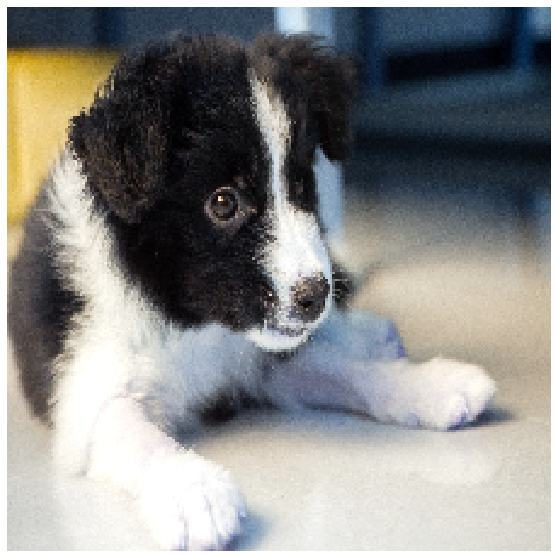

In [111]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
%matplotlib inline

##輸入照片
img = cv2.imread("image/Tano.JPG")  
img = cv2.resize(img, (224, 224)).astype(np.uint8)
output = Augmenation(img)

plt.figure(figsize=(10, 10))
for image in images_aug:
    plt.imshow(output.astype(np.uint8))
    plt.axis('off')


# 關閉圖片增強的隨機性：用於 Semantic segmentation 中

In [22]:
class SemanticSementationMask(object):
    def __init__(self, sequence):
        self.sequence = sequence

    def __call__(self, image, mask):
        sequence = self.sequence.to_deterministic() # 用來關閉隨機性，也就是 augmentation 都是相同的參數
        image = sequence.augment_image(image)
        mask = sequence.augment_image(mask)
        image, mask = image.astype(np.float32), mask.astype(np.float32)
        return image, mask